# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Manually selected features

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model

## Load Teranet data

In [3]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 94.56 seconds
with 5,188,513 rows
and 80 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [5]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [6]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.18 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [7]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [8]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.02 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [9]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 44.15 seconds (0.74 minutes)
with 5,188,513 rows
and 110 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=110)


## Join TTS data to Teranet data

In [10]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 59.57 seconds (0.99 minutes)
with 5,188,513 rows
and 116 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=116)


## Take a train-test subset of Teranet records

In [16]:
year_train_test = 2011
year_val1 = 2010
year_val2 = 2012

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

219,130 Teranet records in the train-test subset (records from 2011).
216,492 Teranet records in the validation subset #1 (records from 2010).
205,341 Teranet records in the validation subset #2 (records from 2012).


## Select features

In [12]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=116)

In [17]:
sbs_k9 = ['xy_total_sales', 'pin_prev_sales', 'pin_years_since_last_sale',
          'med_price_xy', 'Avg_HHsize', 'DwelDens', 'Sgl_det', 'CarTrVan_d',
          'Pop_y',
          'lucr_detached', 'lucr', 'lucr_duplex_townhouse',
          'lucr_condo', 'lucr_other']
s = s[sbs_k9]
s_val1 = s_val1[sbs_k9]
s_val2 = s_val2[sbs_k9]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

141,760 rows in train-test subset, 141,176 rows in validation subset #1, 138,015 rows in validation subset #2


## Encode target

In [18]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               45697
detached            50934
duplex_townhouse    12639
other               32490
Name: lucr, dtype: int64
0    45697
1    50934
2    12639
3    32490
Name: lucr_e, dtype: int64
condo               46211
detached            52310
duplex_townhouse    13204
other               29451
Name: lucr, dtype: int64
0    46211
1    52310
2    13204
3    29451
Name: lucr_e, dtype: int64
condo               41594
detached            50392
duplex_townhouse    12247
other               33782
Name: lucr, dtype: int64
0    41594
1    50392
2    12247
3    33782
Name: lucr_e, dtype: int64
Land use encoded!


## Exploratory Data Analysis (EDA)

In [19]:
condo_corr = s.corr()['lucr_condo_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
detached_corr = s.corr()['lucr_detached_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
duplex_townhouse_corr = \
    s.corr()['lucr_duplex_townhouse_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
other_corr = s.corr()['lucr_other_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

targets_corr = pd.merge(
    pd.merge(
        pd.merge(condo_corr, detached_corr, on='var'), 
    duplex_townhouse_corr, on='var'), 
               other_corr, on='var')
mask1 = targets_corr['var'].isin(['lucr_e', 'lucr_detached_e', 'lucr_duplex_townhouse_e', 'lucr_condo_e', 'lucr_other_e'])
targets_corr = targets_corr[~mask1]
targets_corr_tidy = pd.melt(targets_corr, id_vars='var').sort_values('var')

print_top = 10
print("----- Pearson correlation coefficient between features and target classes"
      "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value').head(print_top),
      "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                           var                 variable     value
9              xy_total_sales          lucr_detached_e -0.410360
14                   DwelDens          lucr_detached_e -0.319135
4                  Avg_HHsize             lucr_condo_e -0.294145
31                 Avg_HHsize             lucr_other_e -0.277737
6                     Sgl_det             lucr_condo_e -0.274660
29  pin_years_since_last_sale             lucr_other_e -0.196978
18             xy_total_sales  lucr_duplex_townhouse_e -0.171426
23                   DwelDens  lucr_duplex_townhouse_e -0.112252
16                 CarTrVan_d          lucr_detached_e -0.104688
2   pin_years_since_last_sale             lucr_condo_e -0.082960 

         strongest positive correlation (top 10):
                           var                 variable     value
13                 Avg_HHsize          lu

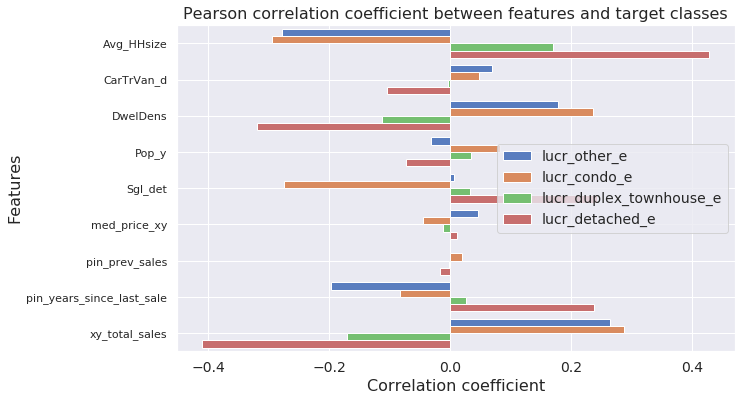

In [21]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
            palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Correlation coefficient", fontsize=16)
ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/sbs_9f_lucr_corr.png", dpi=300, bbox_inches='tight')

## Prepare features

#### Select features and target

In [22]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'pin_prev_sales', 'pin_years_since_last_sale',
       'med_price_xy', 'Avg_HHsize', 'DwelDens', 'Sgl_det', 'CarTrVan_d',
       'Pop_y'],
      dtype='object')

In [23]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [45697 50934 12639 32490]
Labels counts in y_train: [31988 35654  8847 22743]
Labels counts in y_test: [13709 15280  3792  9747]
Labels counts in y_val1: [46211 52310 13204 29451]
Labels counts in y_val2: [41594 50392 12247 33782]


#### Standardize features

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [26]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Train and test classification algorithms

#### Perceptron learning algorithm

In [27]:
model_name = 'Perceptron (raw features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Perceptron (standardized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Perceptron (normalized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Perceptron (raw features) fit, took 0.83 seconds (0.01 minutes)
accuracy: train=0.29, test=0.29, validation #1=0.28, validation #2=0.30

Perceptron (standardized features) fit, took 0.55 seconds (0.01 minutes)
accuracy: train=0.65, test=0.64, validation #1=0.66, validation #2=0.64

Perceptron (normalized features) fit, took 0.47 seconds (0.01 minutes)
accuracy: train=0.66, test=0.66, validation #1=0.68, validation #2=0.65


#### Logistic regression

In [29]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=labels_list)

model_name = 'Logistic regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 4.01 seconds (0.07 minutes)
accuracy: train=0.55, test=0.55, validation #1=0.56, validation #2=0.55


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (standardized features) fit, took 2.24 seconds (0.04 minutes)
accuracy: train=0.70, test=0.70, validation #1=0.71, validation #2=0.68

Logistic regression (normalized features) fit, took 2.40 seconds (0.04 minutes)
accuracy: train=0.67, test=0.67, validation #1=0.66, validation #2=0.66


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


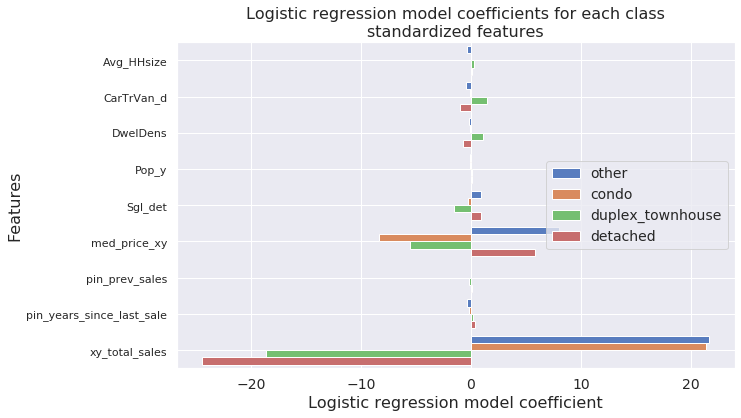

In [31]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression model coefficients for each class\nstandardized features", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/lr_sbs9f_feats_norm_coefs.png", dpi=300, bbox_inches='tight')

In [42]:
c = 1.0
model_name = 'Logistic regression with L1 regularization, C={0} (raw features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
lr_coef_raw = fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=labels_list)

model_name = 'Logistic regression with L1 regularization, C={0} (standardized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
lr_coef_std = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                        return_coefs=True, feat_names=feat_cols, class_names=labels_list)

model_name = 'Logistic regression with L1 regularization, C={0} (normalized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_std, y_val1, X_val2_std, y_val2)


Logistic regression with L1 regularization, C=1.0 (raw features) fit, took 3.90 seconds (0.07 minutes)
accuracy: train=0.70, test=0.70, validation #1=0.71, validation #2=0.68


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Logistic regression with L1 regularization, C=1.0 (standardized features) fit, took 17.55 seconds (0.29 minutes)
accuracy: train=0.69, test=0.69, validation #1=0.70, validation #2=0.68

Logistic regression with L1 regularization, C=1.0 (normalized features) fit, took 3.98 seconds (0.07 minutes)
accuracy: train=0.69, test=0.69, validation #1=0.59, validation #2=0.56


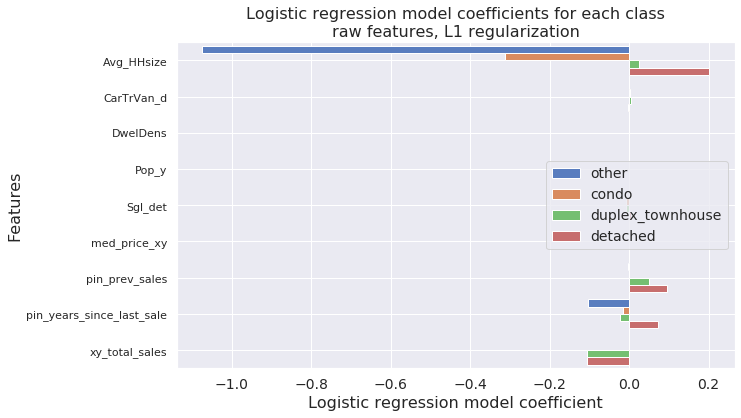

In [43]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef_raw.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression model coefficients for each class\nraw features, L1 regularization", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/lr_sbs9f_feats_norm_coefs.png", dpi=300, bbox_inches='tight')

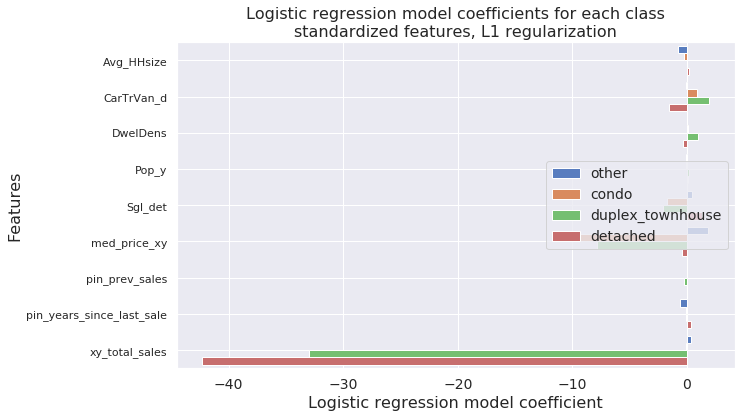

In [44]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef_std.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression model coefficients for each class\nstandardized features, L1 regularization", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/lr_sbs9f_feats_norm_coefs.png", dpi=300, bbox_inches='tight')

#### Decision Tree

In [47]:
max_depth = 4
model_name = 'Decision Tree (raw features, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Decision Tree (raw features, max_depth=4) fit, took 0.44 seconds (0.01 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.77, validation #2=0.75


In [48]:
max_depth = 4
model_name = 'Decision Tree (raw features, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=labels_list,
                           feature_names=feat_cols, out_file='../../results/tree{0}_sbs9f_features.dot'.format(max_depth))
# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')

In [49]:
max_depth = 20
model_name = 'Decision Tree (raw features, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Decision Tree (raw features, max_depth=20) fit, took 1.20 seconds (0.02 minutes)
accuracy: train=0.98, test=0.90, validation #1=0.88, validation #2=0.87


In [50]:
max_depth = 20
model_name = 'Decision Tree (raw features, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=labels_list,
                           feature_names=feat_cols, out_file='../../results/tree{0}_sbs9f_features.dot'.format(max_depth))
# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')

#### Random Forest

In [51]:
n_estimators = 25
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_estimators, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Random Forest (raw features, 25 estimators) fit, took 2.56 seconds (0.04 minutes)
accuracy: train=1.00, test=0.93, validation #1=0.91, validation #2=0.90


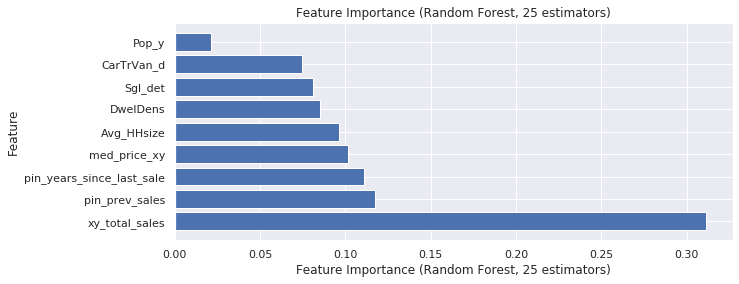

In [54]:
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('Feature Importance (Random Forest, {0} estimators)'.format(n_estimators))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance (Random Forest, {0} estimators)'.format(n_estimators))
ax.set_ylabel('Feature')
f.savefig('../../results/plots/rf{0}_sbs9f_feature_importance.png'.format(n_estimators), dpi=300)

In [55]:
n_estimators = 1000
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_estimators, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Random Forest (raw features, 1000 estimators) fit, took 44.89 seconds (0.75 minutes)
accuracy: train=1.00, test=0.93, validation #1=0.92, validation #2=0.91


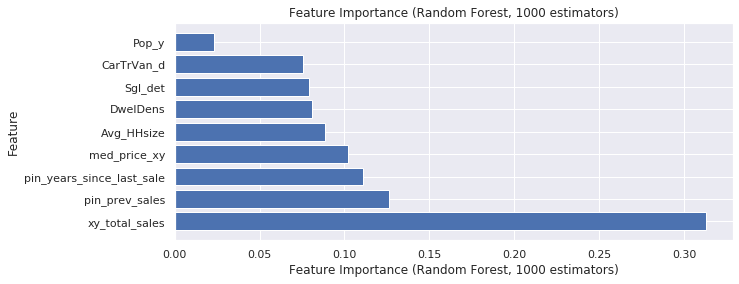

In [56]:
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('Feature Importance (Random Forest, {0} estimators)'.format(n_estimators))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance (Random Forest, {0} estimators)'.format(n_estimators))
ax.set_ylabel('Feature')
f.savefig('../../results/plots/rf{0}_sbs9f_feature_importance.png'.format(n_estimators), dpi=300)

#### K-nearest neighbors

In [57]:
model_name = 'K-nearest neighbors (raw features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'K-nearest neighbors (normalized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


K-nearest neighbors (raw features) fit, took 30.09 seconds (0.50 minutes)
accuracy: train=0.86, test=0.80, validation #1=0.80, validation #2=0.77

K-nearest neighbors (normalized features) fit, took 39.61 seconds (0.66 minutes)
accuracy: train=0.91, test=0.87, validation #1=0.85, validation #2=0.84
